# GENERATIVE ADVERSARIAL NETWORKS(GANs)

## Synopsis of GANs

In general an Artificial Neural Network(ANN) are great in classifying/predicting things; however what sets GAN apart from these traditional networks is that it can ** create for itself**. 

An ANN for reference : 
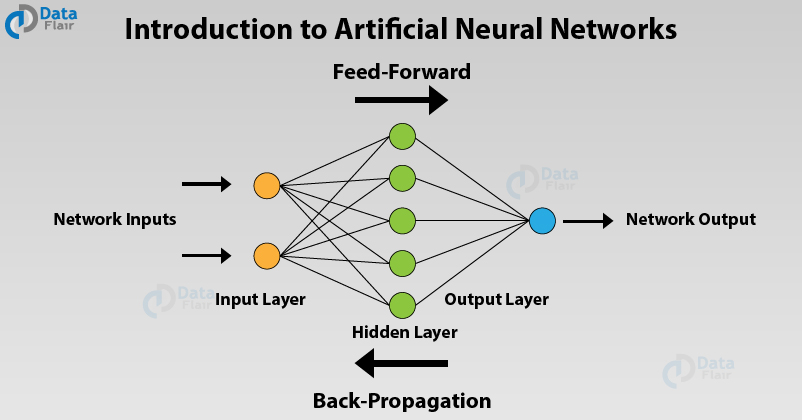

According to OpenAI, algorithms which are able to create data might be substantially better at understanding the intricacies of the world. In words of Richard Feynman :

*"What I cannot create, I do not understand."* 

GANs belong to a set of algorithms known as **Generative Models**, which is in turn a sub class of **Unsupervised Machine Learning**, that is we **do not** explicitly need labelled data in order to train our model.
GAN architecture comprises of 2 parts : 
* Generator
* Discriminator - The adversarial section

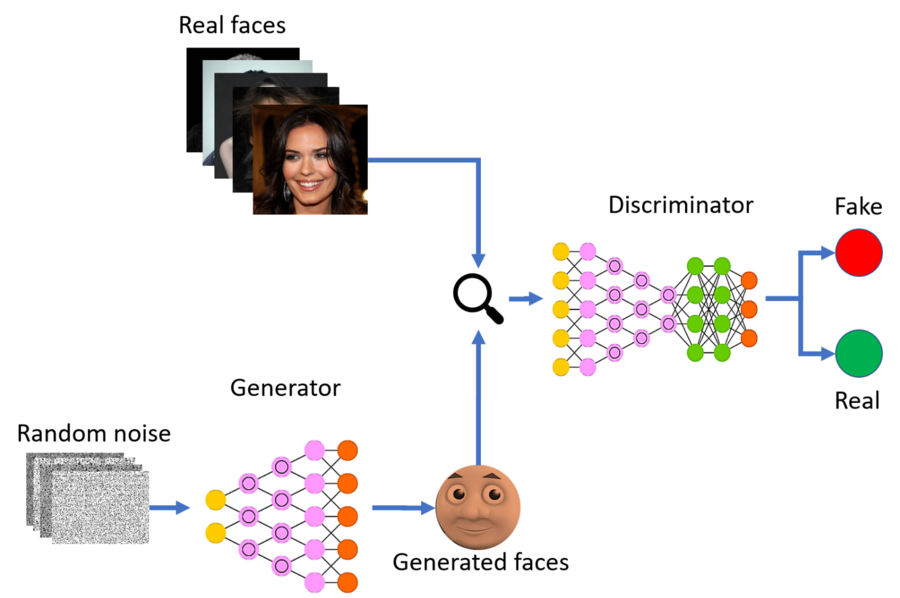

Both the generator and discriminator are closely **entangled** with one another. When the entire architecture is trained, we bring both of them **from scratch**.



Hence, in a way they learn by competing against each other, thereby making each other better.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

1. torch.autograd provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

2. The torch.autograd.Variable class was used to create tensors that support gradient calculations and operation tracking but as of PyTorch v0.4.0 Variable class has been deprecated. torch.Tensor and torch.autograd.Variable are now the same class.

**PyTorch Autograd package - The Heart of PyTorch framework**


( https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95 )

> To deal with hyper-planes in a 14-dimensional space, visualize a 3-D space and say ‘fourteen’ to yourself very loudly. Everyone does it —Geoffrey Hinton

This is where PyTorch’s autograd comes in. It abstracts the complicated mathematics and helps us “magically” calculate gradients of high dimensional curves with only a few lines of code. 

**Tensors:** In simple words, its just an n-dimensional array in PyTorch. Tensors support some additional enhancements which make them unique: Apart from CPU, they can be loaded or the GPU for faster computations.

*By PyTorch’s design, gradients can only be calculated for floating point tensors*

**Autograd:** This class is an engine to calculate derivatives (Jacobian-vector product to be more precise). It records a graph of all the operations performed on a gradient enabled tensor and creates an acyclic graph called the dynamic computational graph. The leaves of this graph are input tensors and the roots are output tensors. Gradients are calculated by tracing the graph from the root to the leaf and multiplying every gradient in the way using the chain rule. 

> In a way, back propagation is just fancy name for the chain rule — Jeremy Howard

**Dynamic Computational graph** : 

Gradient enabled tensors (variables) along with functions (operations) combine to create the dynamic computational graph.This graph is made dynamically by the autograd class under the hood.


*Reference image : *

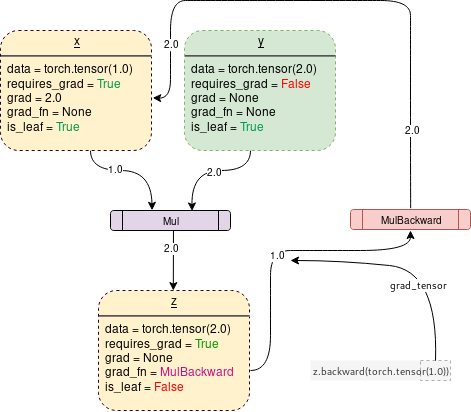

Some attribute of a tensor : 

1. requires_grad: This member, if true starts tracking all the operation history and forms a backward graph for gradient calculation. 

2. grad: grad holds the value of gradient. If requires_grad is False it will hold a None value. Even if requires_grad is True, it will hold a None value unless .backward() function is called from some other node. For example, if you call out.backward() for some variable out that involved x in its calculations then x.grad will hold ∂out/∂x.

3. grad_fn: This is the backward function used to calculate the gradient.

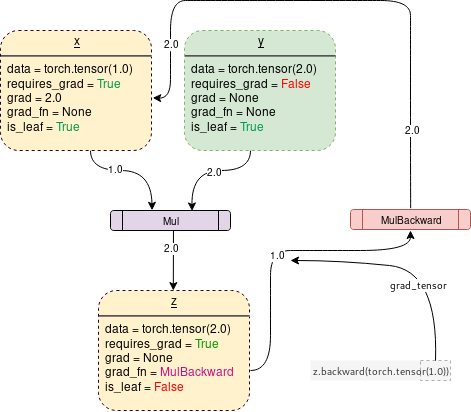


**Backward() function** : 

Backward is the function which actually calculates the gradient by passing it’s argument (1x1 unit tensor by default) through the backward graph all the way up to every leaf node traceable from the calling root tensor. The calculated gradients are then stored in .grad of every leaf node. Remember, the backward graph is already made dynamically during the forward pass. 


In [2]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

In [3]:
torch.set_default_tensor_type("torch.cuda.FloatTensor")
dtype = torch.cuda.FloatTensor

The dataset we’ll be using here is LeCunn’s MNIST dataset, consisting of about 60.000 black and white images of handwritten digits, each with size 28x28 pixels

**data_loader : **

This will help us iterate over the data set.

In [4]:
data_transform = transforms.Compose([transforms.ToTensor()])
mnist_trainset = datasets.MNIST(root = './data', train = True, download = True, transform = data_transform)
data_loader= torch.utils.data.DataLoader(mnist_trainset, batch_size = 100, shuffle = True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





creating loader with data, so that we can iterate over it

In [5]:
num_batches = len(data_loader)
num_batches

600

Here we will unroll the tensor into a 1-D vector. A batch of images will be passed here. So, all the 2-D image tensors in this batch will be unrolled into 1-D, while maintaing the size of the batch.

In [6]:
def image_to_vector(image_batch):
    vector_batch = image_batch.view(image_batch.size(0), 784)
    return vector_batch

In [7]:
def vector_to_image(vector_batch):
    image_batch = vector_batch.view(vector_batch.size(0), 1, 28, 28)
    return image_batch

In [8]:
def noise(num_of_samples):
    noise = torch.randn(num_of_samples,100)
    return noise

In [9]:
class D(torch.nn.Module):
    def __init__(self):
        super(D, self).__init__()
        input_dim = 784
        output_dim = 1
        
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(input_dim, 1024), 
                                      torch.nn.LeakyReLU(0.2),
                                      torch.nn.Dropout(0.3))
        self.fc2 = torch.nn.Sequential(torch.nn.Linear(1024, 512),
                                      torch.nn.LeakyReLU(0.2),
                                      torch.nn.Dropout(0.3))
        self.fc3 = torch.nn.Sequential(torch.nn.Linear(512, 256),
                                      torch.nn.LeakyReLU(0.2),
                                      torch.nn.Dropout(0.3))
        self.fc4 = torch.nn.Sequential(torch.nn.Linear(256, output_dim),
                                      torch.nn.Sigmoid())
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
d = D()
d.cuda()

D(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc4): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [10]:
class G(torch.nn.Module):
    def __init__(self):
        super(G, self).__init__()
        input_dim = 100
        output_dim = 784
        
        self.fc1 = torch.nn.Sequential(torch.nn.Linear(input_dim, 256),
                                      torch.nn.LeakyReLU(0.2))
        self.fc2 = torch.nn.Sequential(torch.nn.Linear(256, 512),
                                      torch.nn.LeakyReLU(0.2))
        self.fc3 = torch.nn.Sequential(torch.nn.Linear(512, 1024),
                                      torch.nn.LeakyReLU(0.2))
        self.fc4 = torch.nn.Sequential(torch.nn.Linear(1024, output_dim),
                                      torch.nn.Tanh())
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x
g = G()
g.cuda()    

G(
  (fc1): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (fc4): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)

In [11]:
d_optimizer = torch.optim.Adam(d.parameters(), lr = 0.0001)
g_optimizer = torch.optim.Adam(g.parameters(), lr = 0.0001)

**BCELoss :**

Blog : (https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

BCELoss creates a criterion that measures the Binary Cross Entropy between the target and the output. If you are training a binary classifier, chances are you are using binary cross-entropy / log loss as your loss function. 

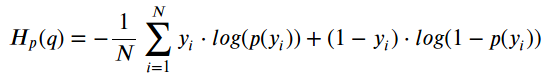

Entropy is a measure of the uncertainty associated with a given distribution q(y).

**Cross Entropy : **

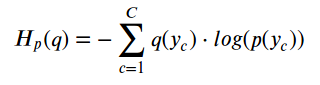

In [12]:
loss_fn = torch.nn.BCELoss()

Real-images targets are always ones, while the fake-images targets are zero, so it would be helpful to define the following functions:

In [13]:
def real_target(batch_size):
    data = torch.ones(batch_size, 1)
    return data

In [14]:
def fake_target(batch_size):
    data = torch.zeros(batch_size,1)
    return data

In [15]:
def train_dis(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    
    #real data
    y_real = real_target(n)
    y_pred_real = d(real_data)
    loss_real = loss_fn(y_pred_real, y_real)
    loss_real.backward()
    
    # fake data
    y_fake = fake_target(n)
    y_pred_fake = d(fake_data)
    loss_fake = loss_fn(y_pred_fake, y_fake)
    loss_fake.backward()
    
    optimizer.step()
    return (loss_real + loss_fake)

In [16]:
def train_gen(optimizer, fake_data): # torch.Size([100, 784])
    n = fake_data.size(0) # 100
    optimizer.zero_grad()
    
    y_real = real_target(n)
    y_pred = d(fake_data)
    loss = loss_fn(y_pred,y_real)
    loss.backward()
    
    optimizer.step()
    return loss

In [17]:
num_test_samples = 4
test_noise = noise(num_test_samples)

In [18]:
test_noise.shape

torch.Size([4, 100])

In [19]:
def display_image(test_images):
    fig, axs= plt.subplots(2,2)
    fig.suptitle("Generated Images")
    
    img = test_images[0]
    img = img.cpu().detach()
    img = img.reshape(28,28)
    axs[0,0].imshow(img, cmap = "binary")
    
    img = test_images[1]
    img = img.cpu().detach()
    img = img.reshape(28,28)
    axs[0,1].imshow(img, cmap = "binary")
    
    img = test_images[2]
    img = img.cpu().detach()
    img = img.reshape(28,28)
    axs[1,0].imshow(img, cmap = "binary")
    
    img = test_images[3]
    img = img.cpu().detach()
    img = img.reshape(28,28)
    axs[1,1].imshow(img, cmap = "binary")
    
    plt.show()

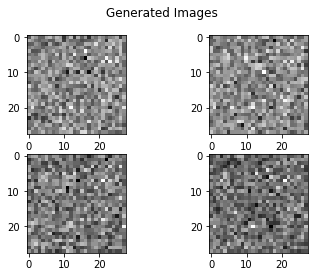


 0 0


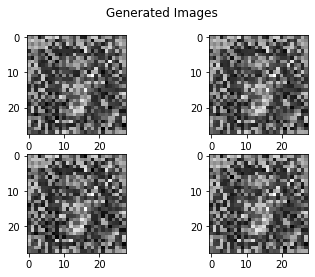


 0 100


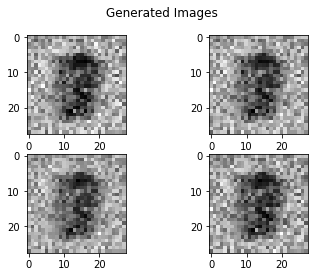


 0 200


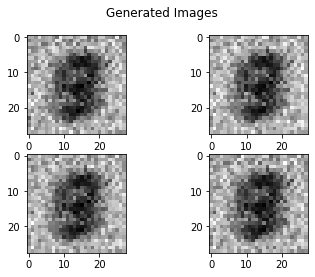


 0 300


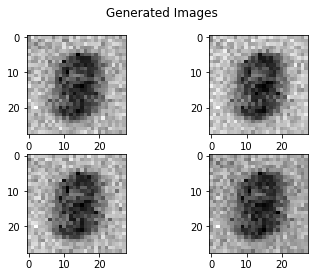


 0 400


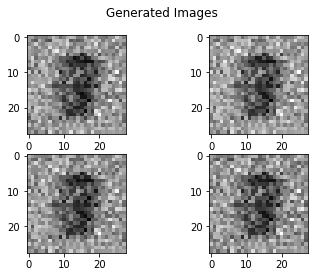


 0 500


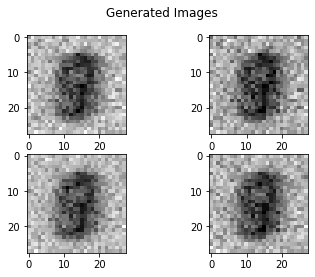


 1 0


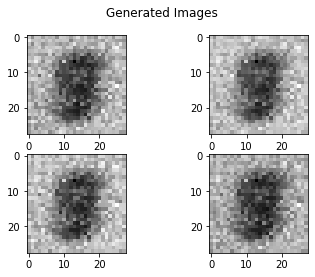


 1 100


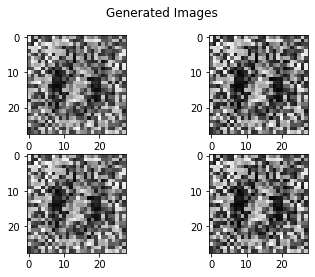


 1 200


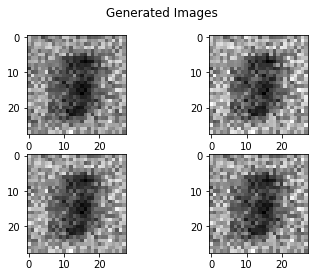


 1 300


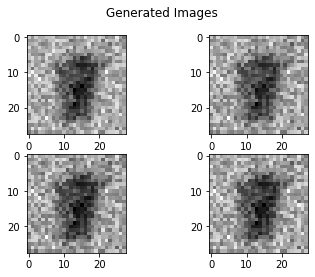


 1 400


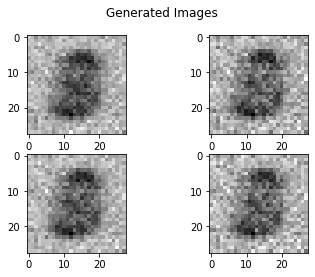


 1 500


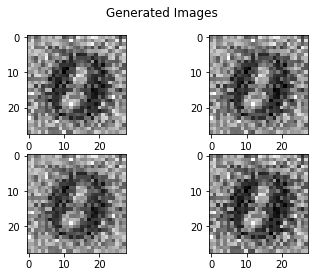


 2 0


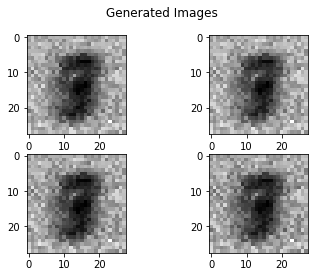


 2 100


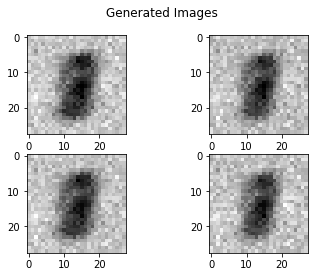


 2 200


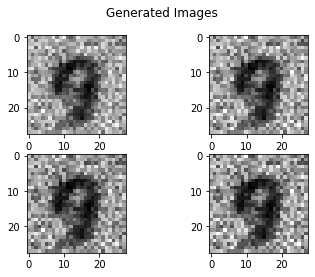


 2 300


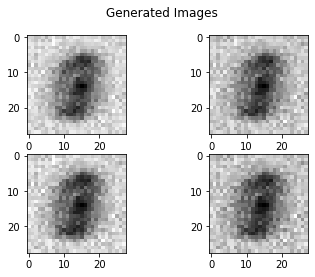


 2 400


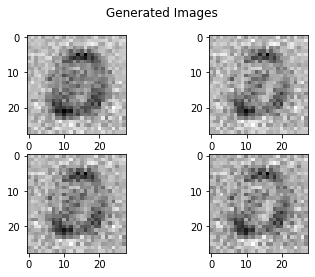


 2 500


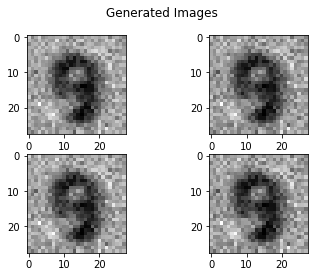


 3 0


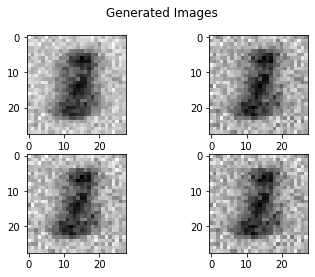


 3 100


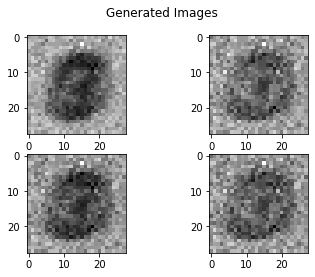


 3 200


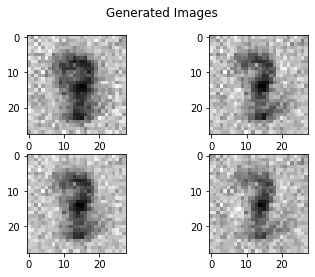


 3 300


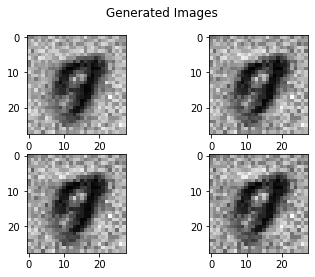


 3 400


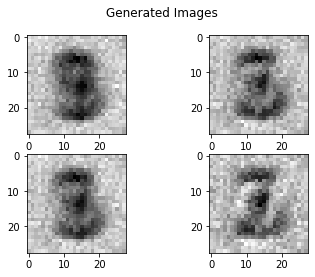


 3 500


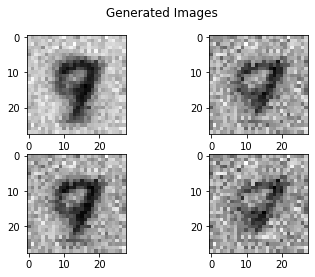


 4 0


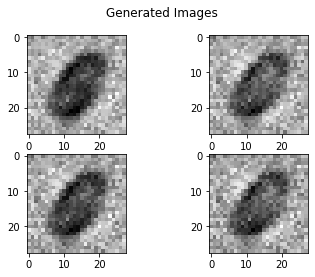


 4 100


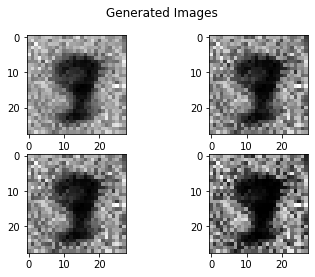


 4 200


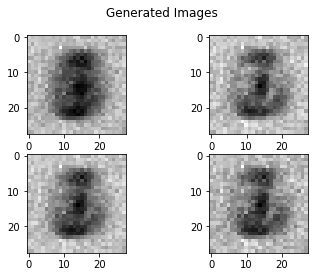


 4 300


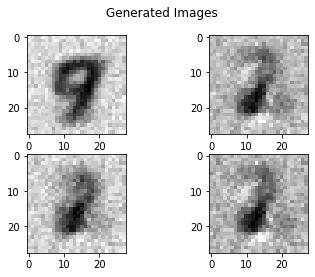


 4 400


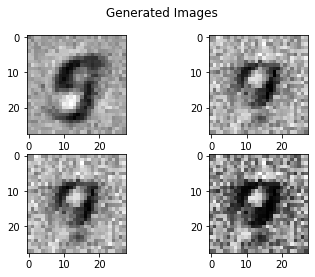


 4 500


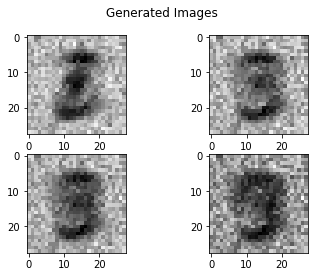


 5 0


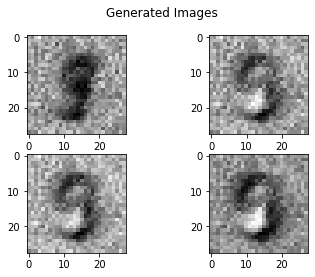


 5 100


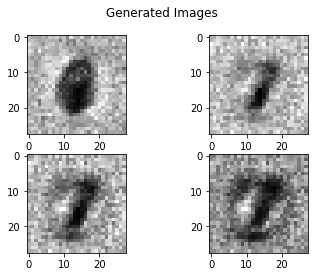


 5 200


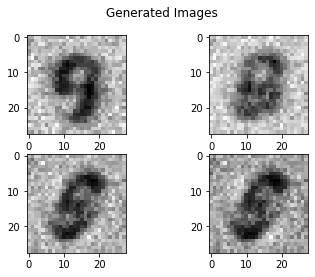


 5 300


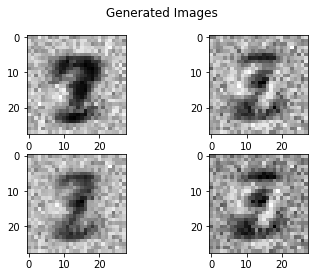


 5 400


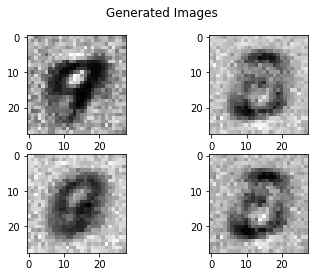


 5 500


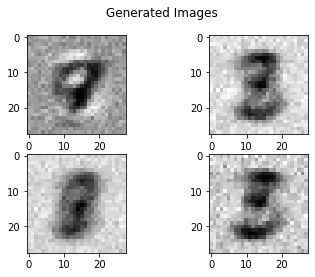


 6 0


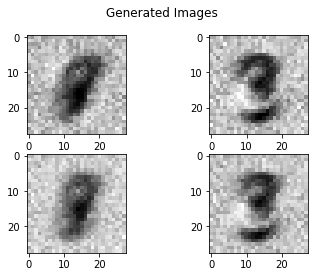


 6 100


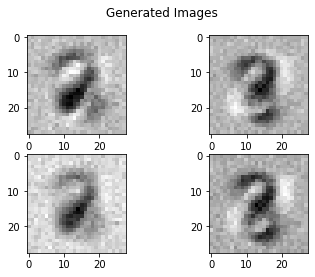


 6 200


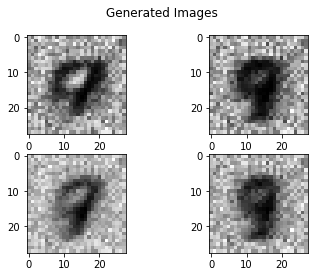


 6 300


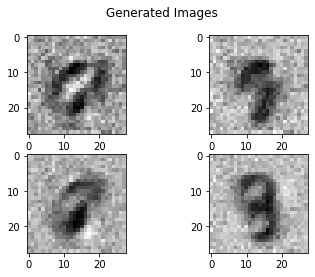


 6 400


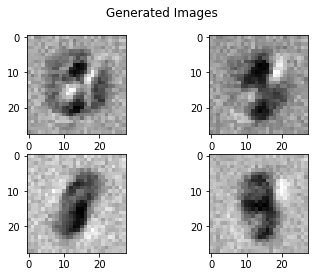


 6 500


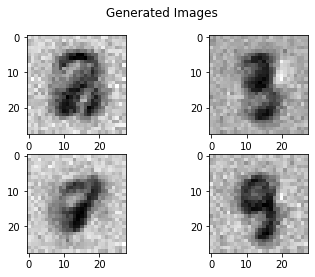


 7 0


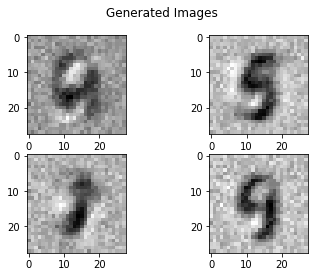


 7 100


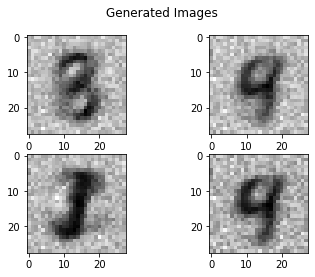


 7 200


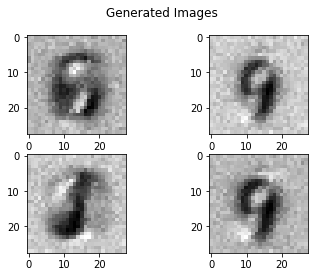


 7 300


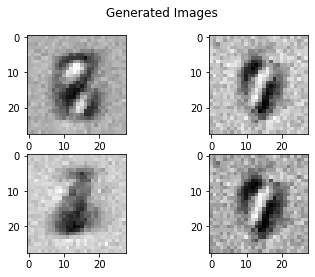


 7 400


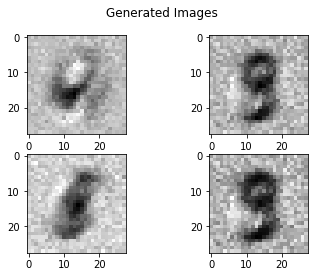


 7 500


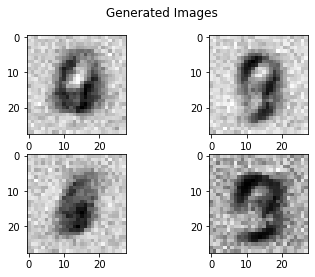


 8 0


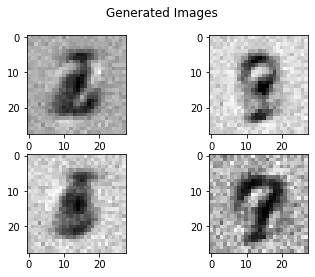


 8 100


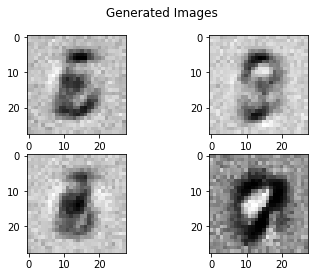


 8 200


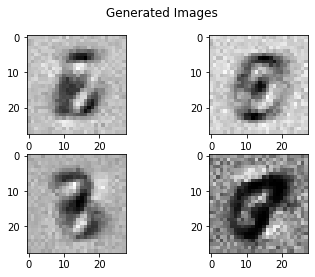


 8 300


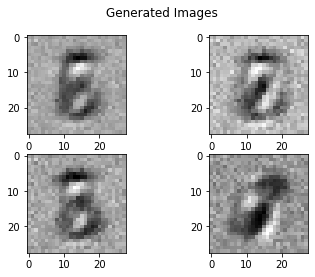


 8 400


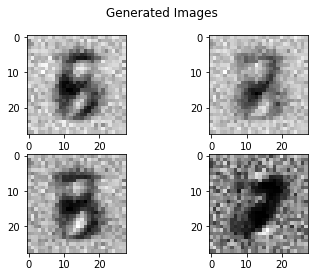


 8 500


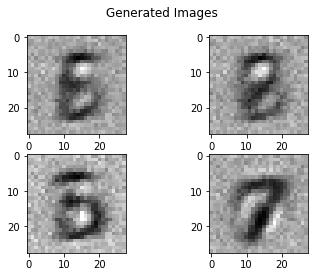


 9 0


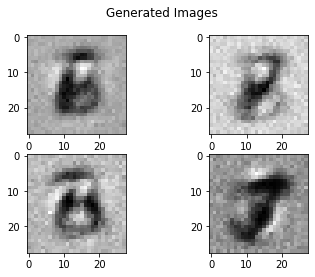


 9 100


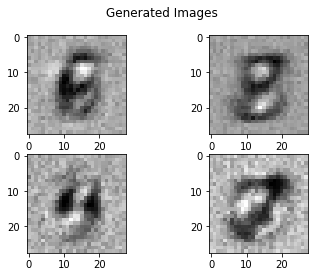


 9 200


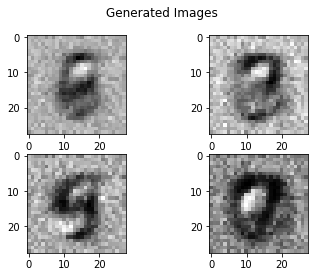


 9 300


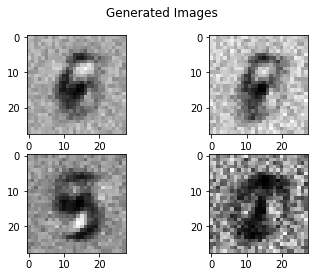


 9 400


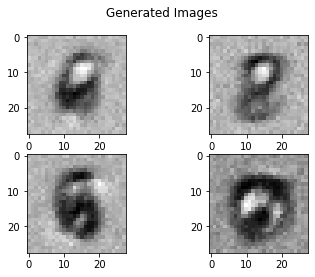


 9 500


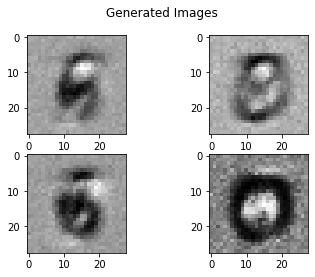


 10 0


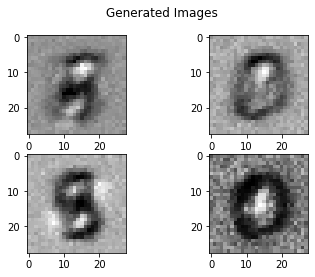


 10 100


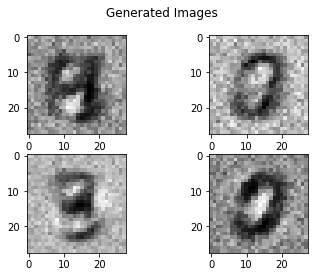


 10 200


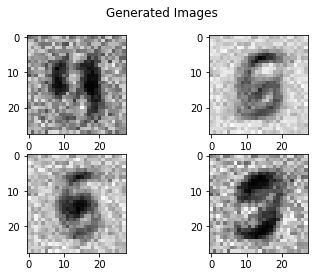


 10 300


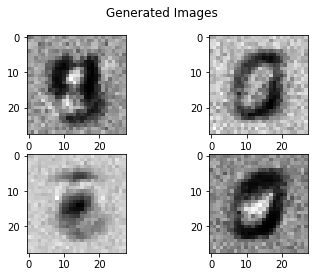


 10 400


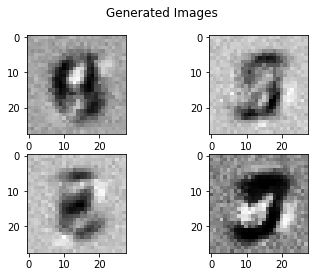


 10 500


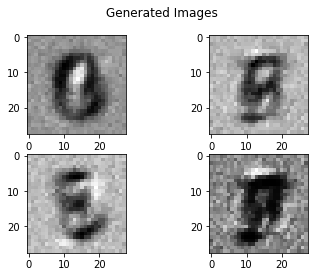


 11 0


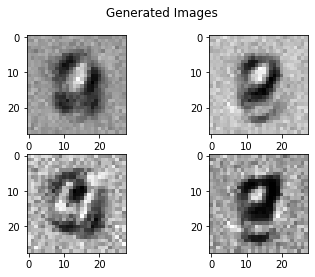


 11 100


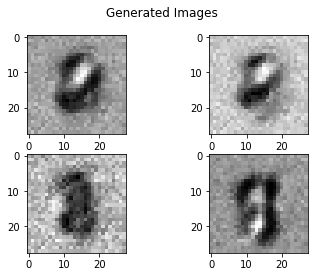


 11 200


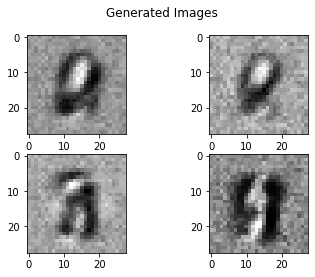


 11 300


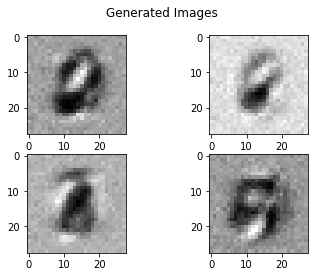


 11 400


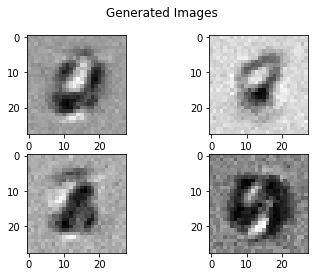


 11 500


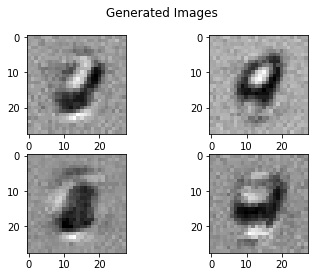


 12 0


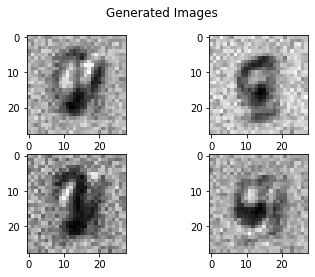


 12 100


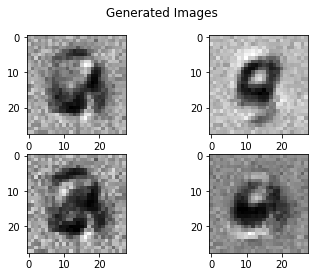


 12 200


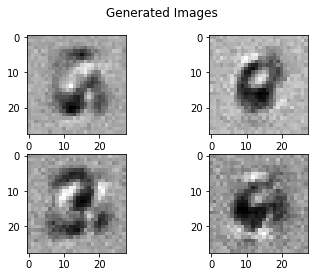


 12 300


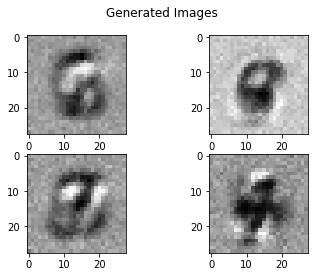


 12 400


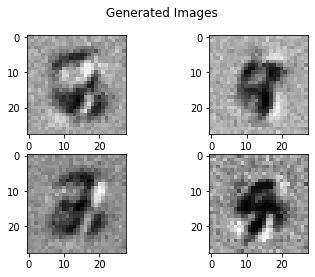


 12 500


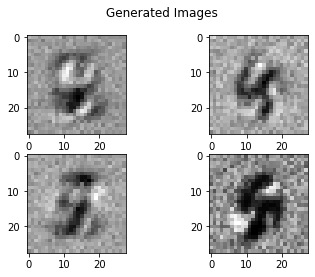


 13 0


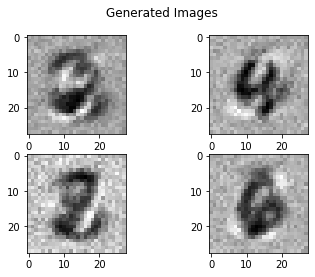


 13 100


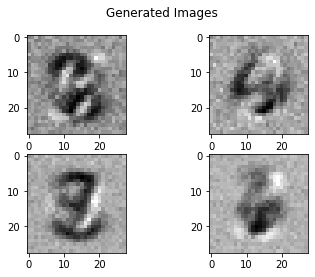


 13 200


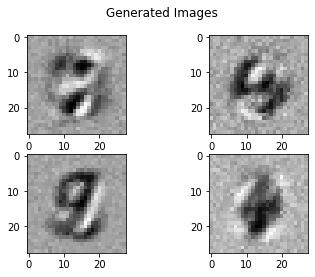


 13 300


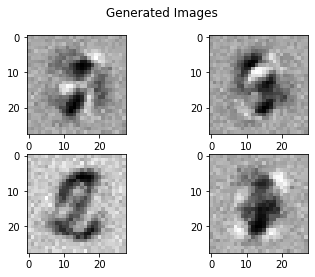


 13 400


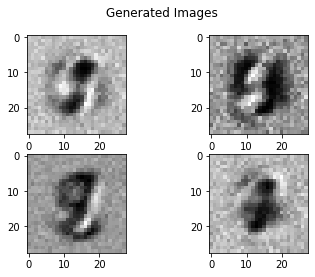


 13 500


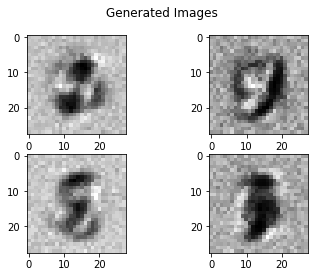


 14 0


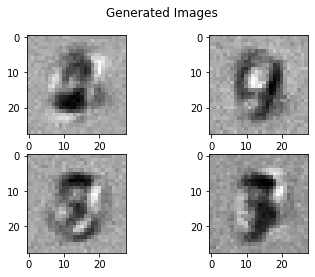


 14 100


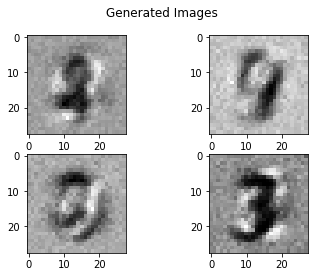


 14 200


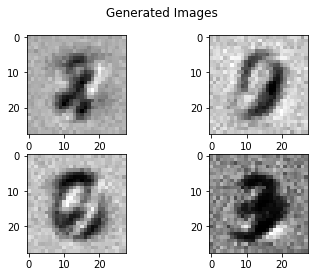


 14 300


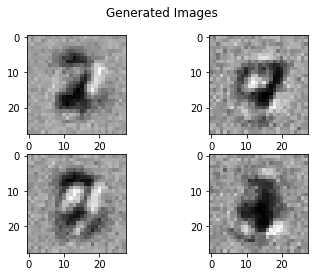


 14 400


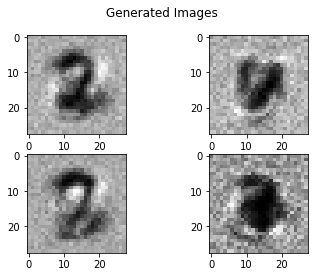


 14 500


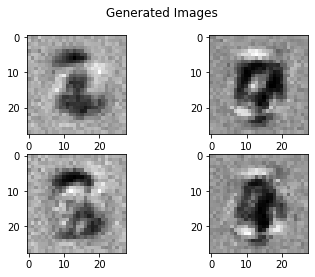


 15 0


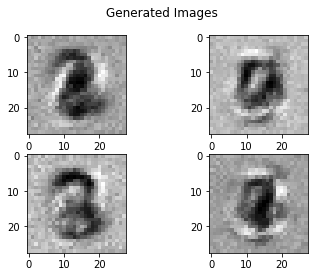


 15 100


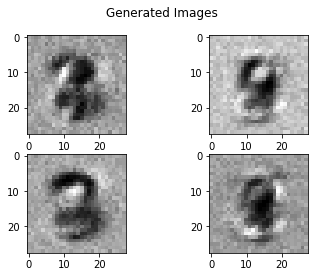


 15 200


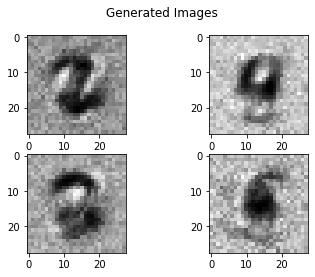


 15 300


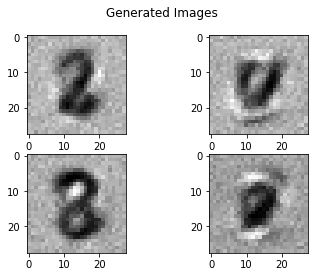


 15 400


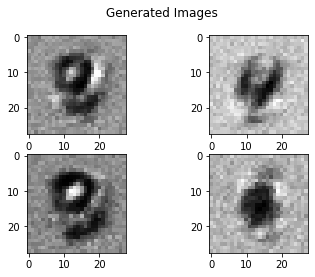


 15 500


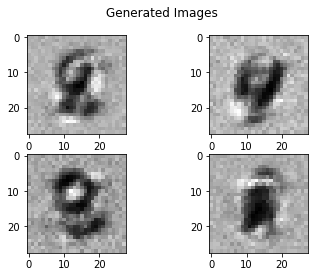


 16 0


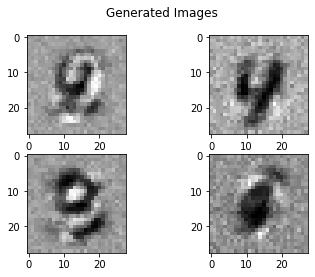


 16 100


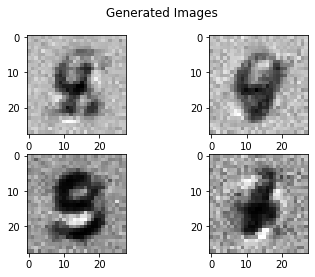


 16 200


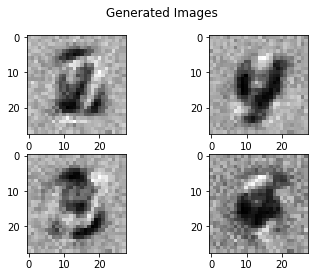


 16 300


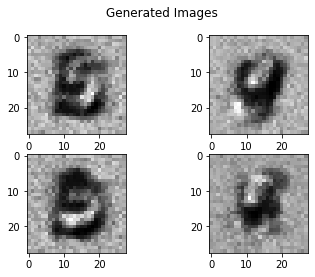


 16 400


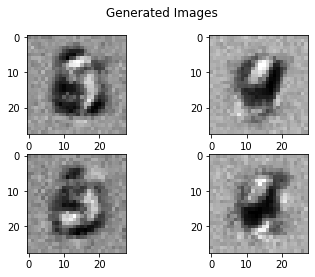


 16 500


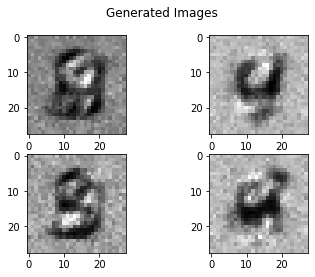


 17 0


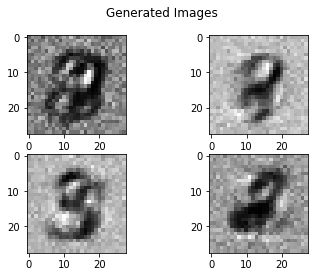


 17 100


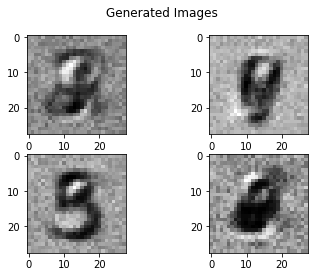


 17 200


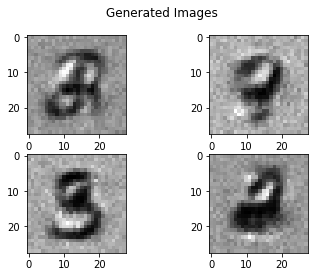


 17 300


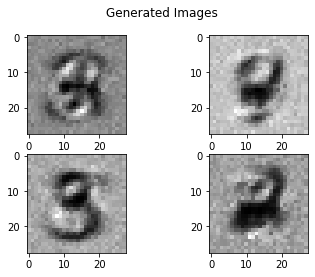


 17 400


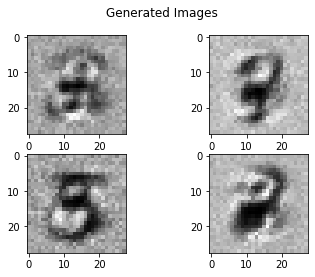


 17 500


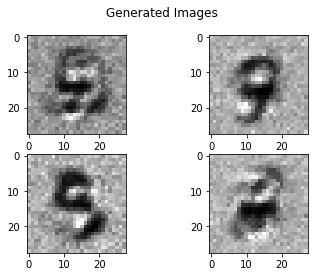


 18 0


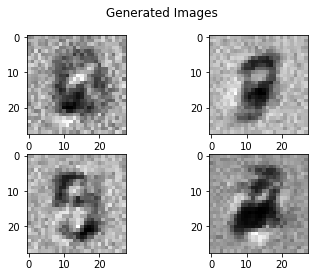


 18 100


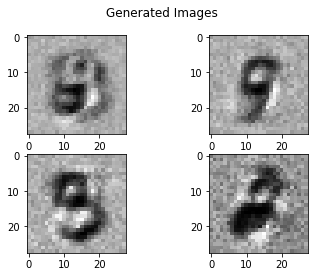


 18 200


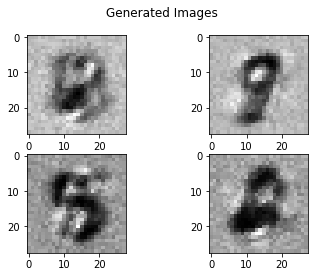


 18 300


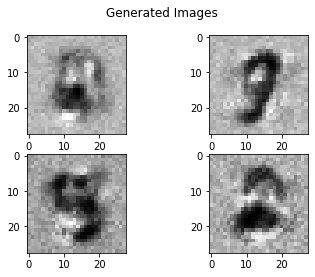


 18 400


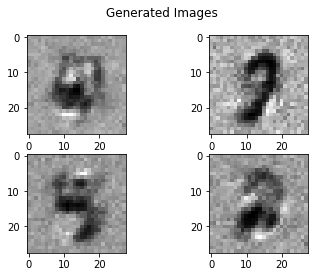


 18 500


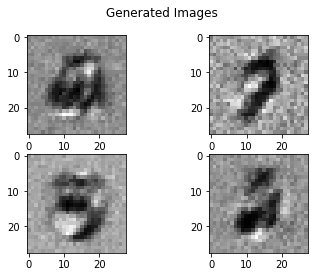


 19 0


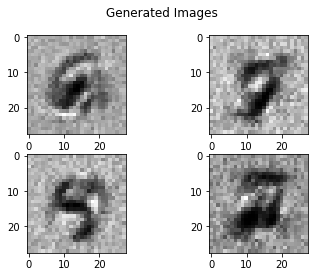


 19 100


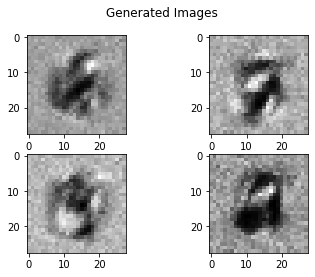


 19 200


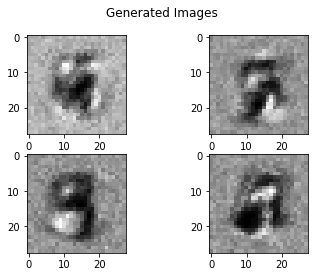


 19 300


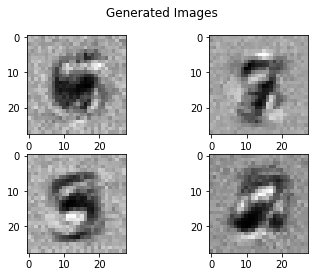


 19 400


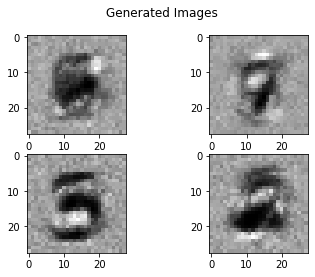


 19 500


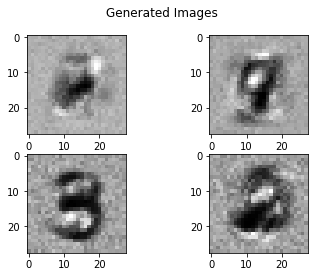


 20 0


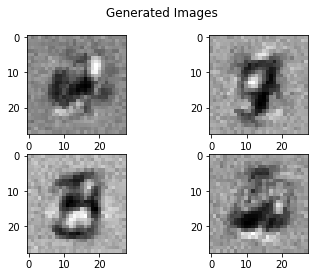


 20 100


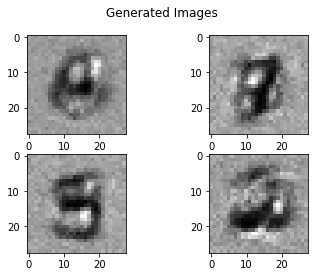


 20 200


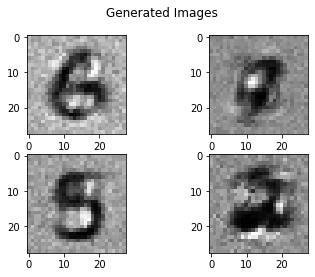


 20 300


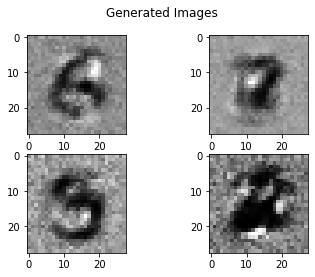


 20 400


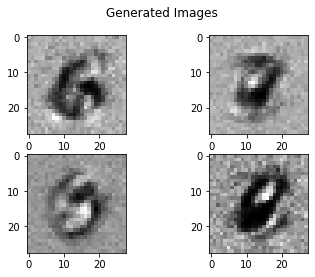


 20 500


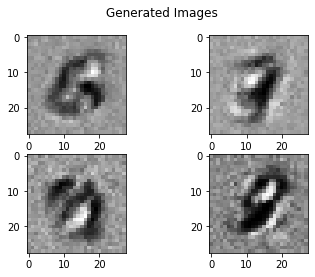


 21 0


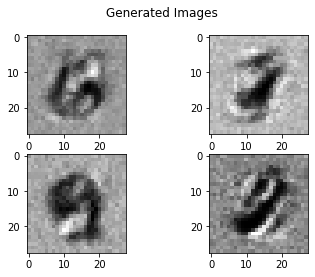


 21 100


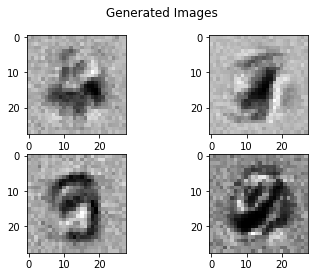


 21 200


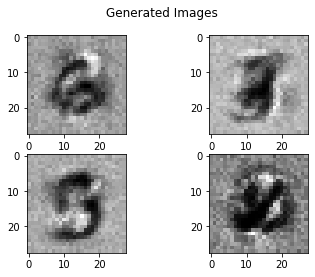


 21 300


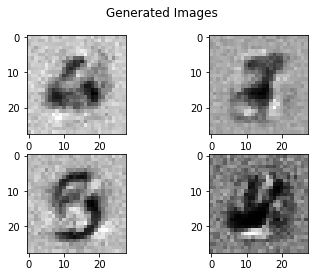


 21 400


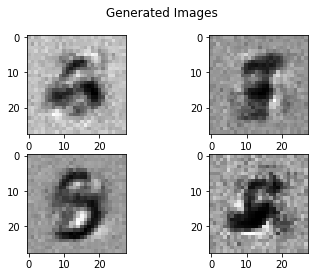


 21 500


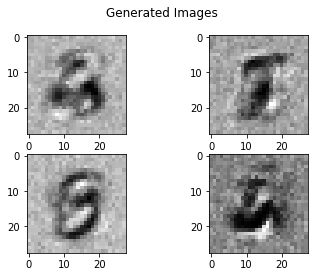


 22 0


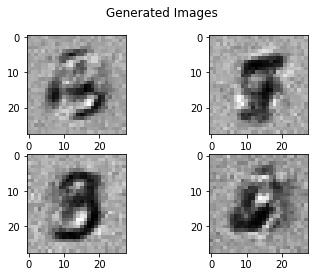


 22 100


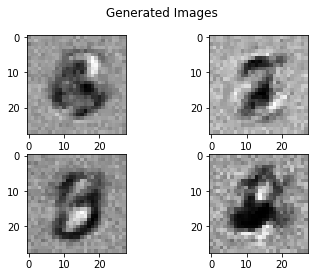


 22 200


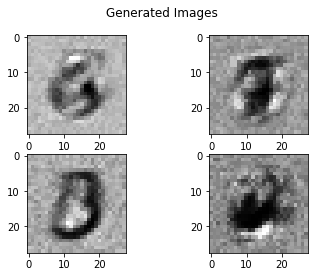


 22 300


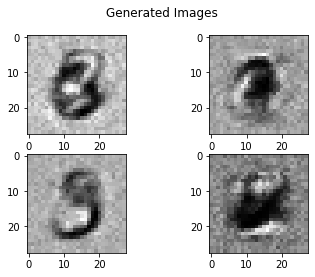


 22 400


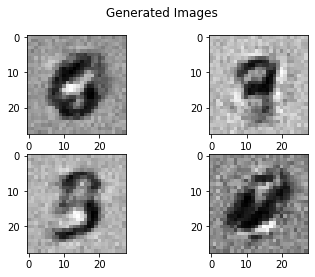


 22 500


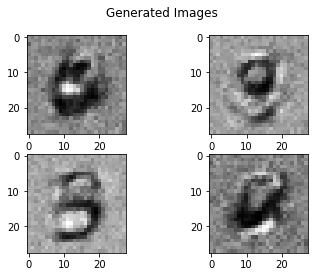


 23 0


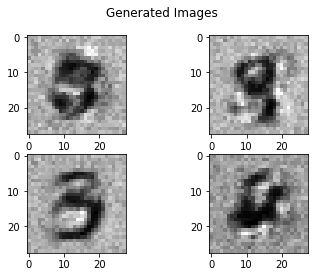


 23 100


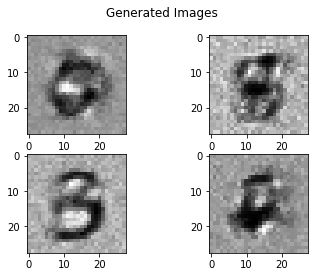


 23 200


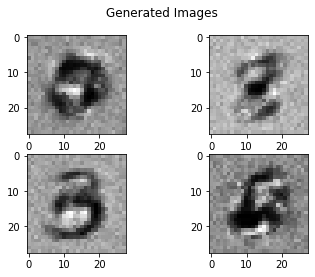


 23 300


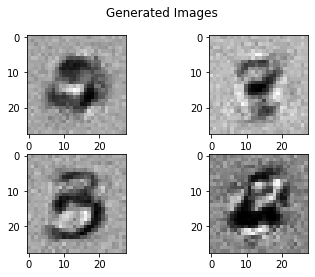


 23 400


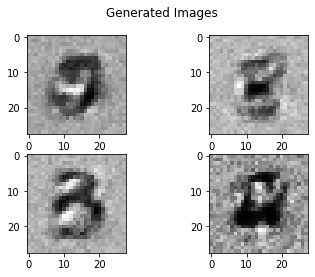


 23 500


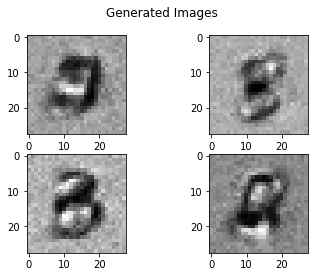


 24 0


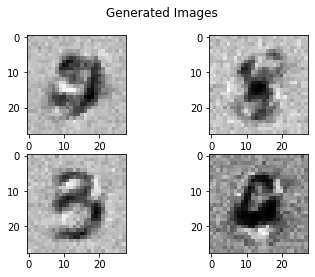


 24 100


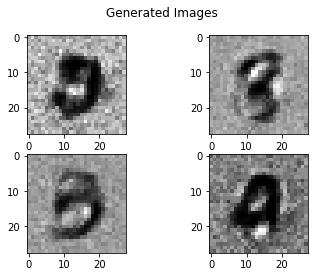


 24 200


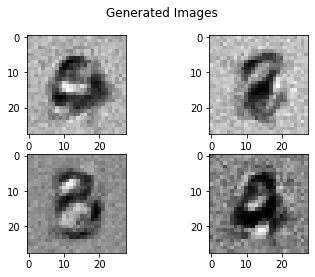


 24 300


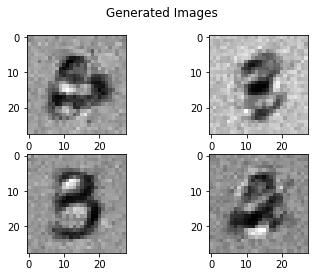


 24 400


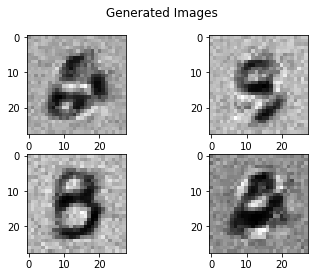


 24 500


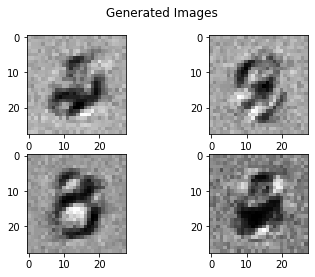


 25 0


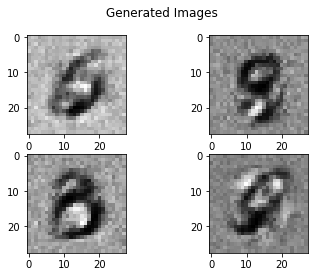


 25 100


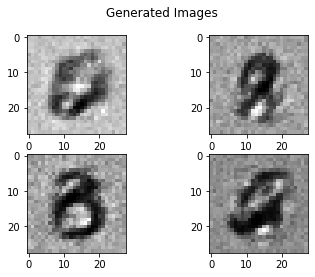


 25 200


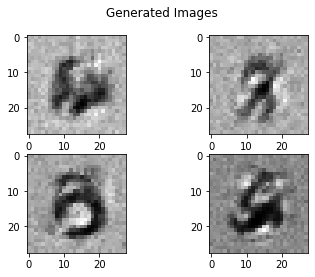


 25 300


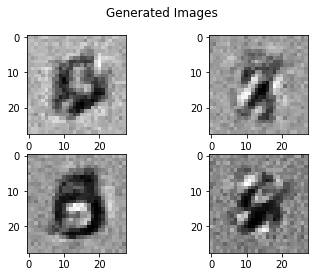


 25 400


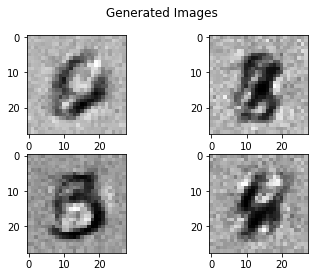


 25 500


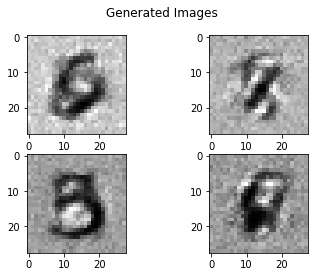


 26 0


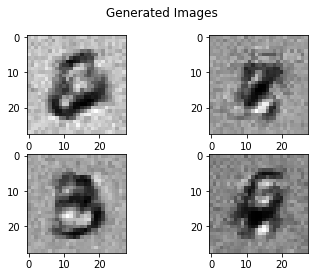


 26 100


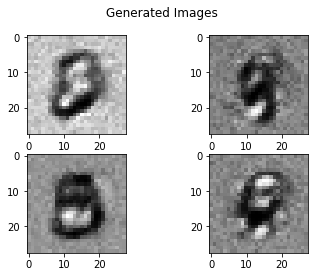


 26 200


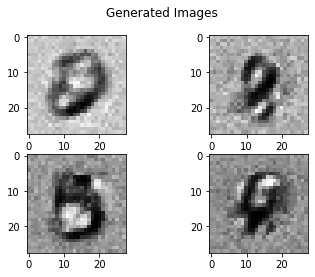


 26 300


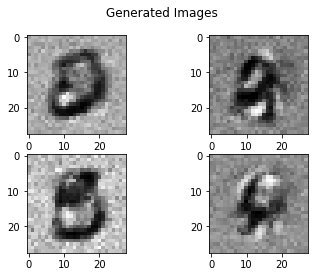


 26 400


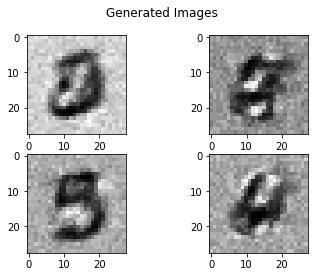


 26 500


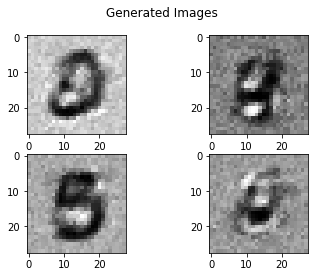


 27 0


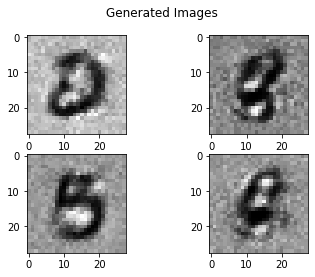


 27 100


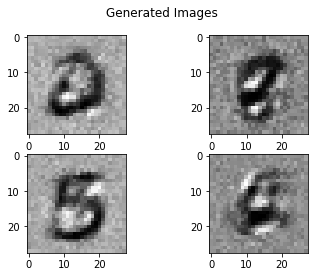


 27 200


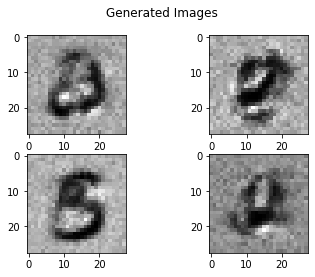


 27 300


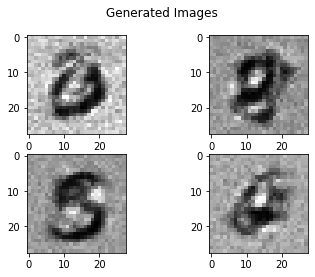


 27 400


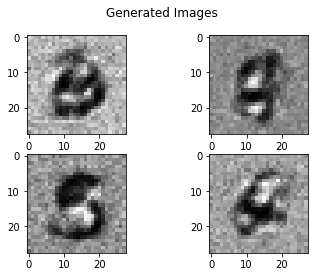


 27 500


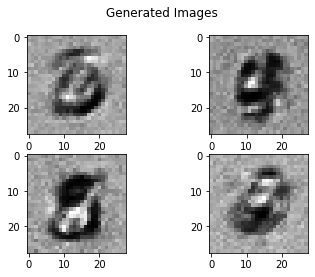


 28 0


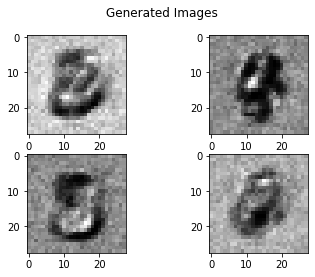


 28 100


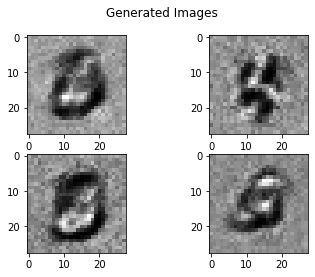


 28 200


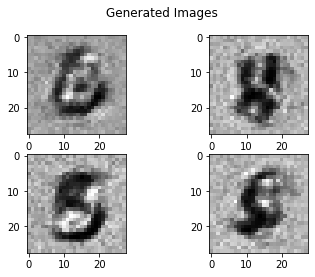


 28 300


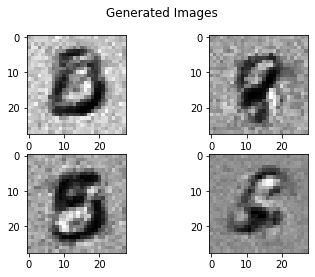


 28 400


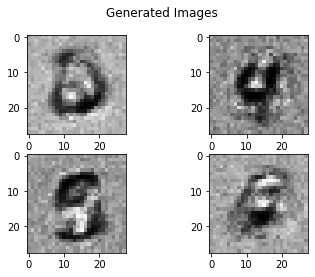


 28 500


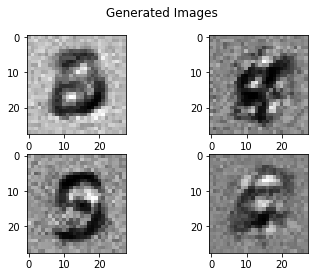


 29 0


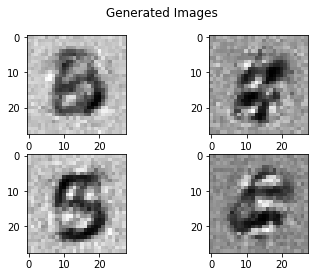


 29 100


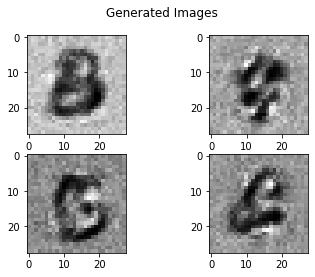


 29 200


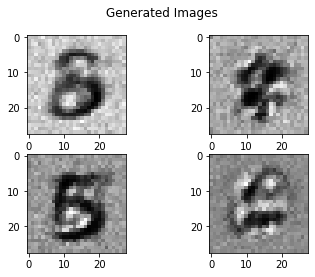


 29 300


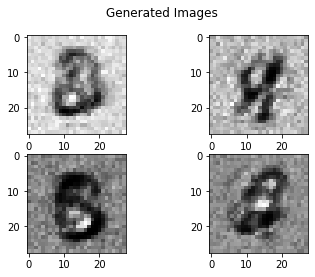


 29 400


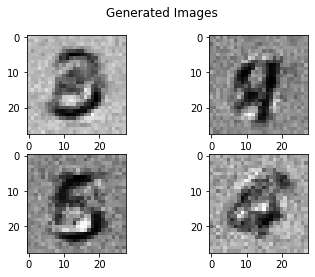


 29 500


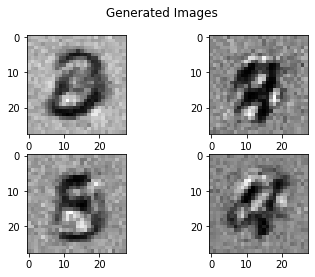


 30 0


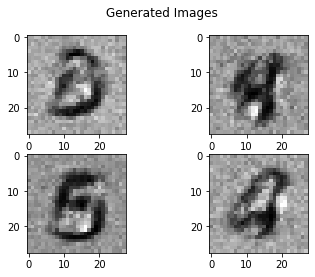


 30 100


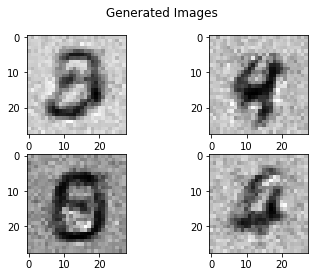


 30 200


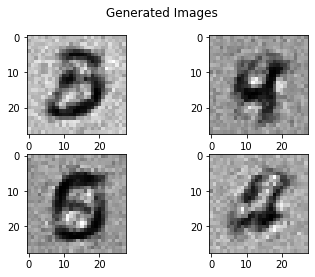


 30 300


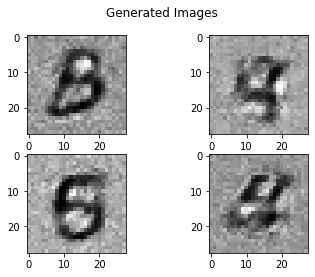


 30 400


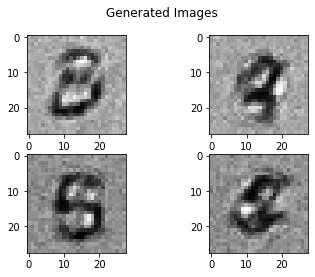


 30 500


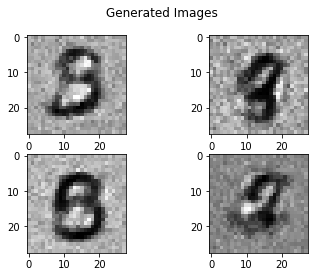


 31 0


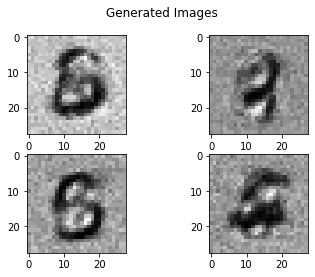


 31 100


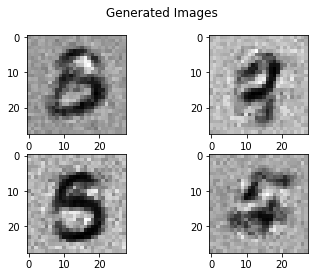


 31 200


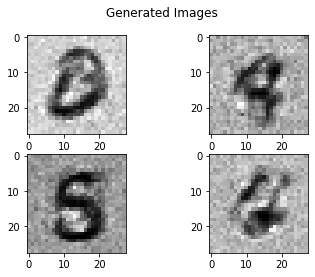


 31 300


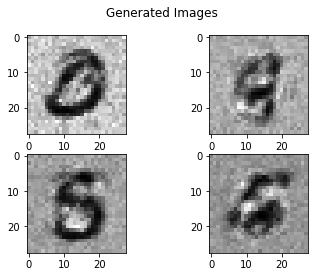


 31 400


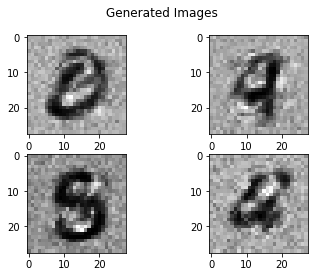


 31 500


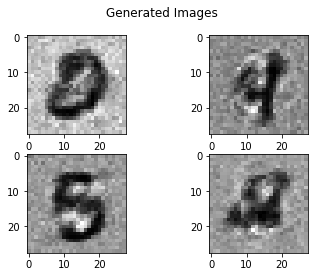


 32 0


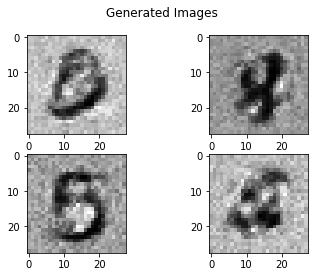


 32 100


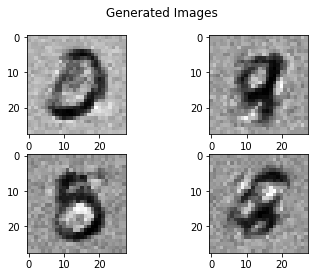


 32 200


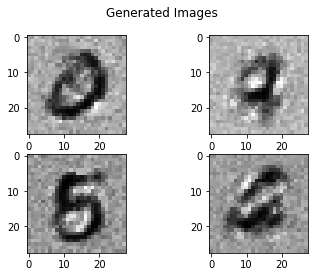


 32 300


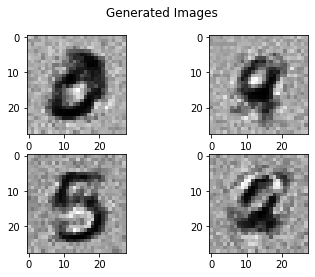


 32 400


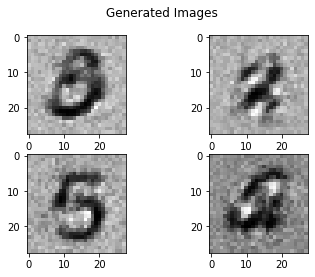


 32 500


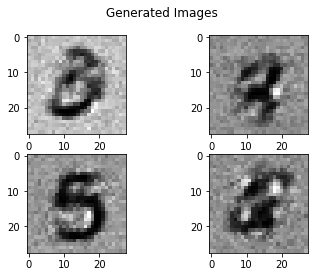


 33 0


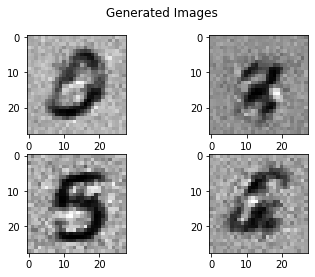


 33 100


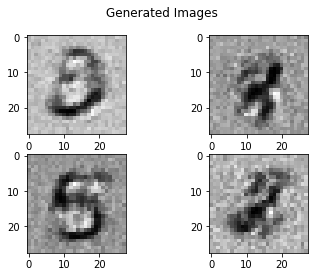


 33 200


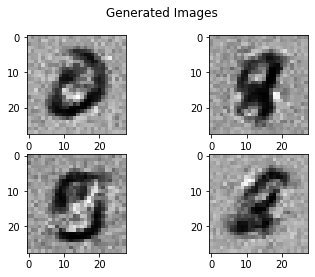


 33 300


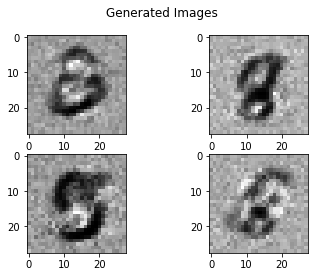


 33 400


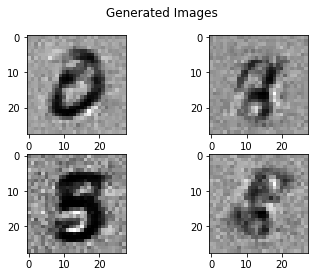


 33 500


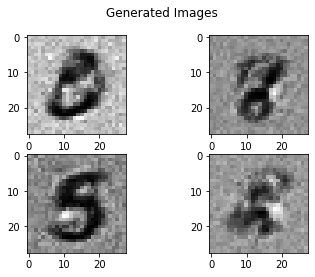


 34 0


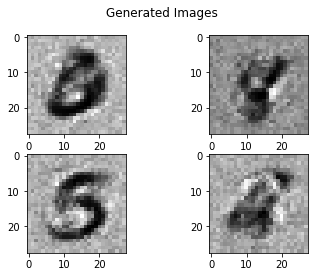


 34 100


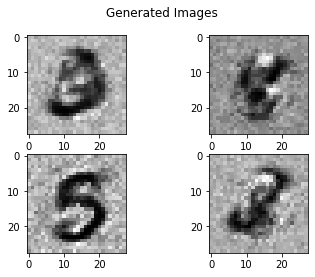


 34 200


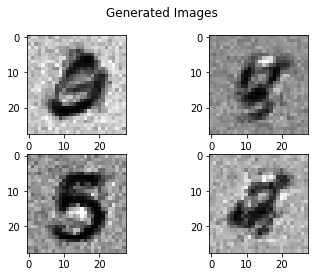


 34 300


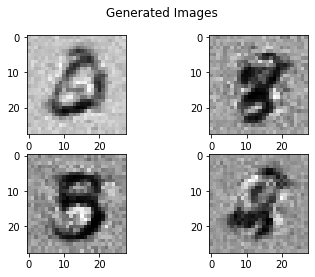


 34 400


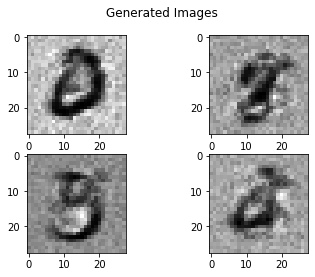


 34 500


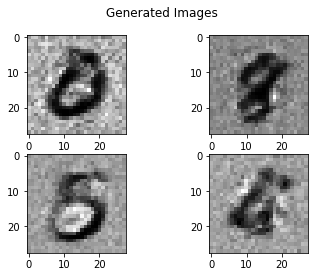


 35 0


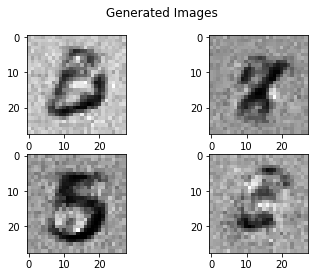


 35 100


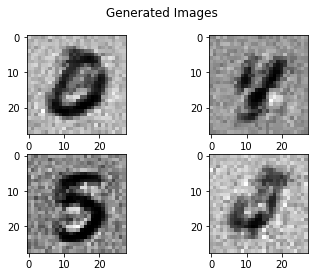


 35 200


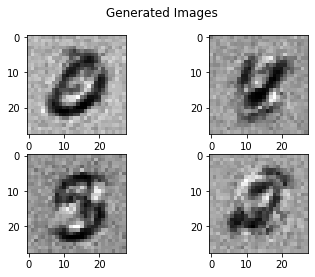


 35 300


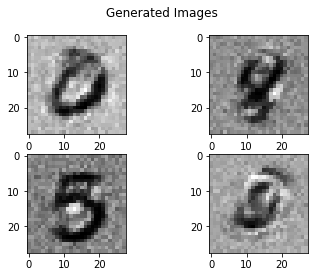


 35 400


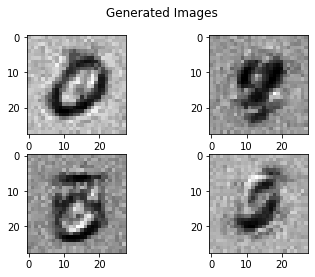


 35 500


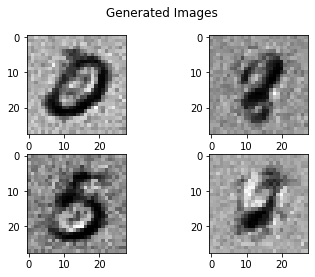


 36 0


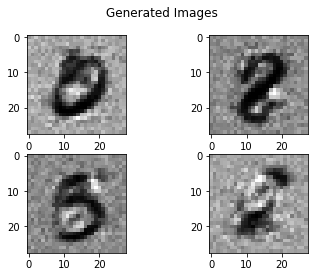


 36 100


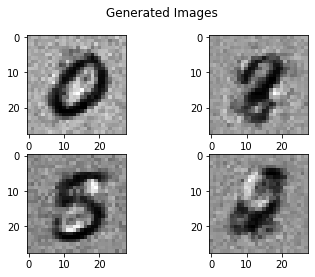


 36 200


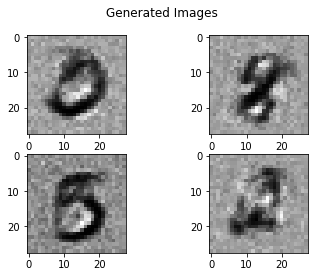


 36 300


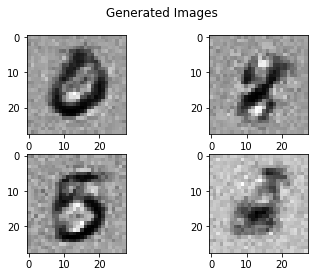


 36 400


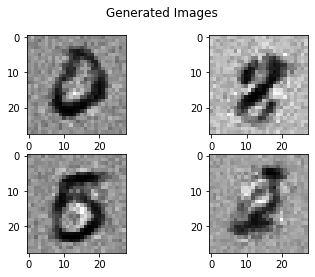


 36 500


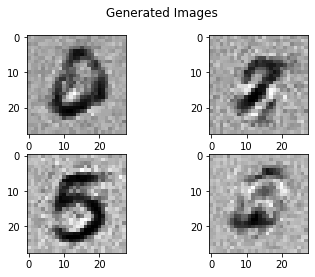


 37 0


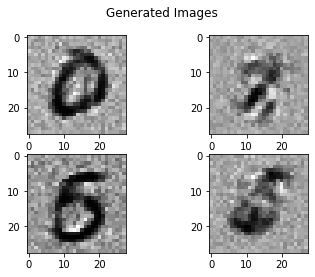


 37 100


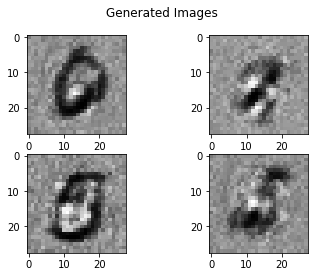


 37 200


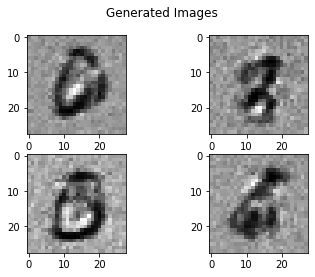


 37 300


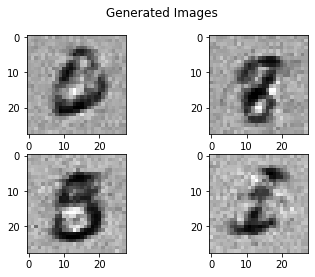


 37 400


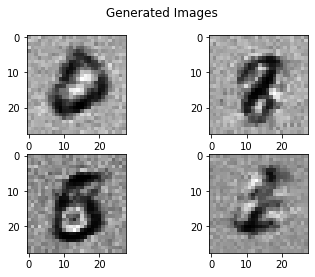


 37 500


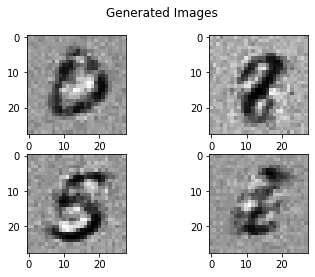


 38 0


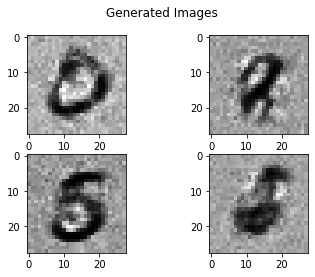


 38 100


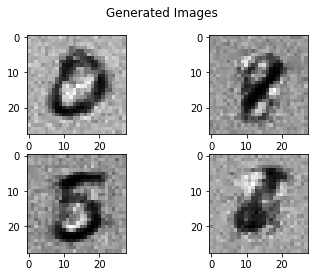


 38 200


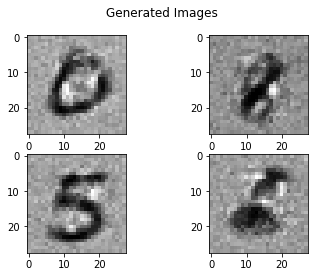


 38 300


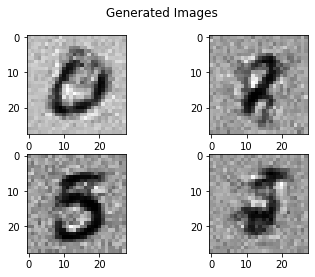


 38 400


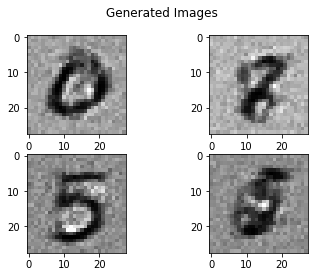


 38 500


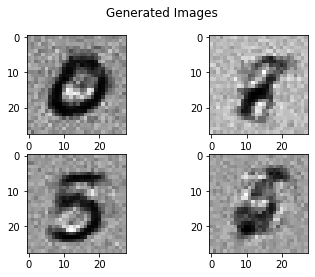


 39 0


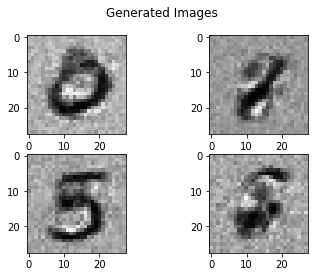


 39 100


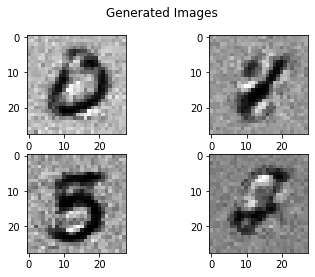


 39 200


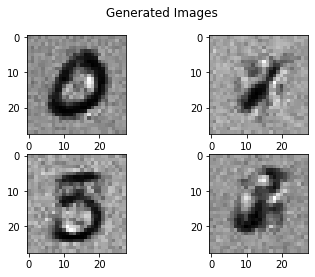


 39 300


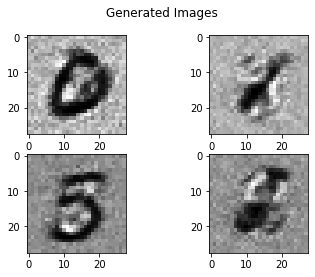


 39 400


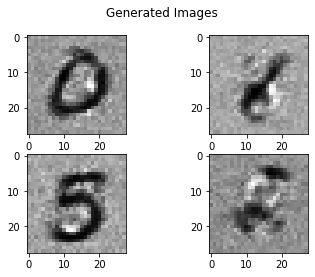


 39 500


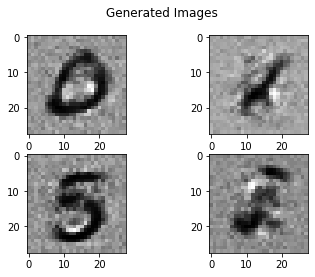


 40 0


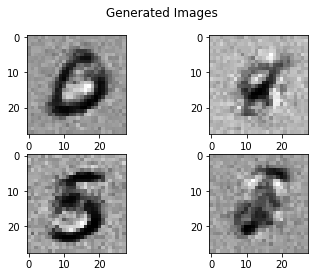


 40 100


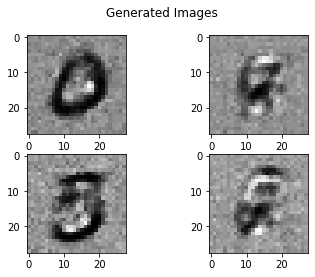


 40 200


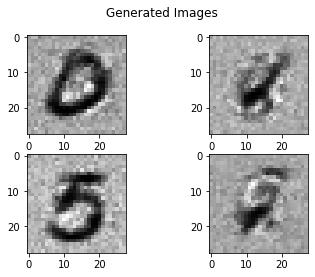


 40 300


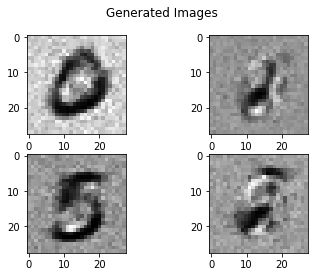


 40 400


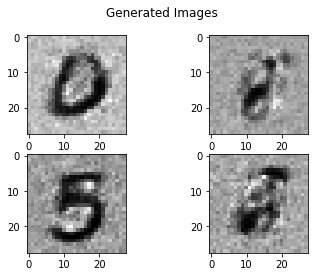


 40 500


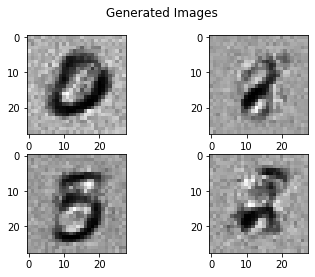


 41 0


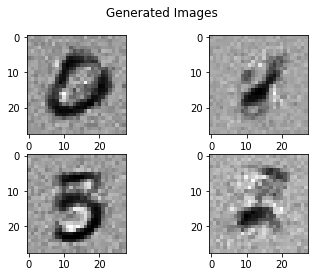


 41 100


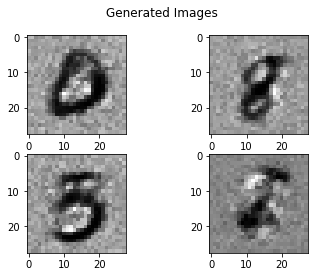


 41 200


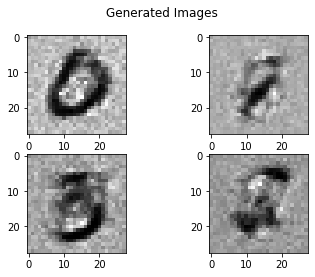


 41 300


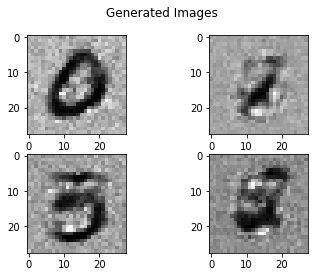


 41 400


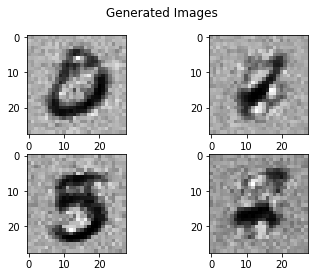


 41 500


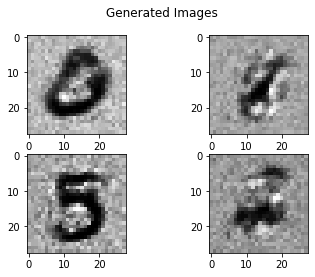


 42 0


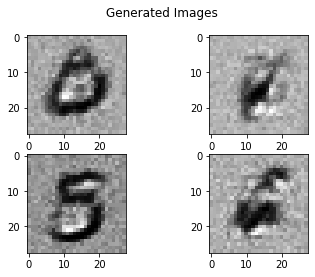


 42 100


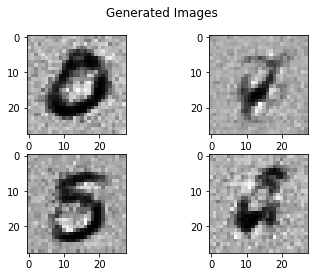


 42 200


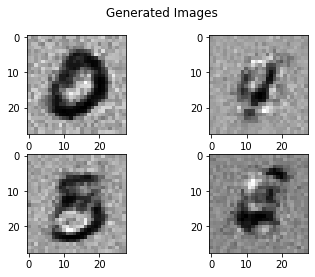


 42 300


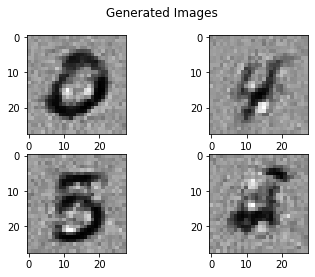


 42 400


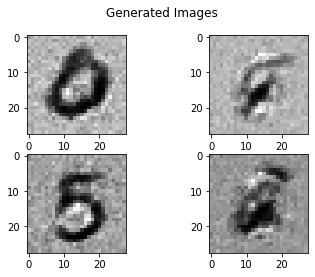


 42 500


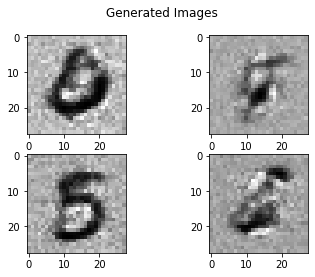


 43 0


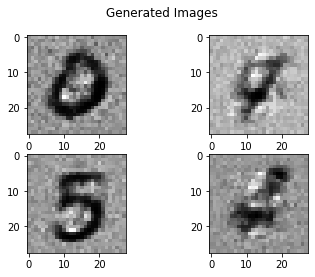


 43 100


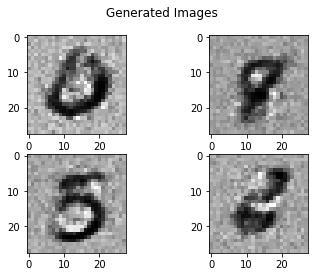


 43 200


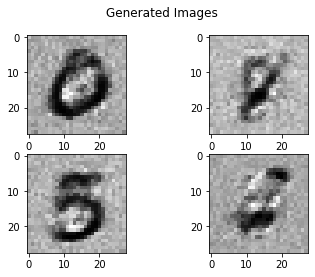


 43 300


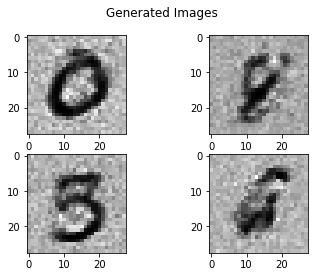


 43 400


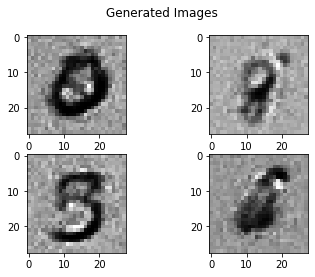


 43 500


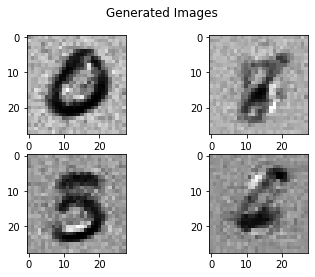


 44 0


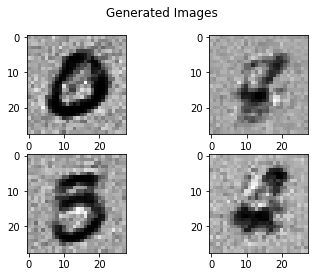


 44 100


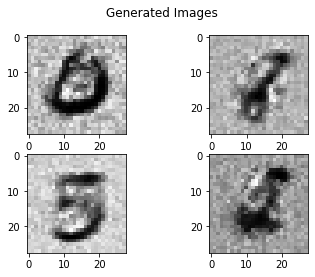


 44 200


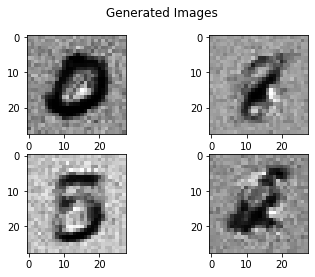


 44 300


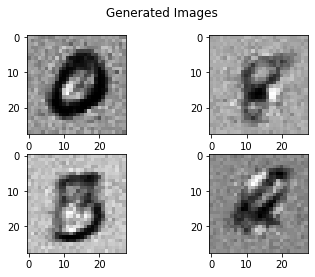


 44 400


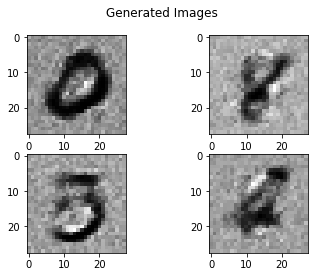


 44 500


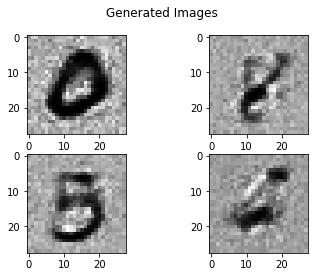


 45 0


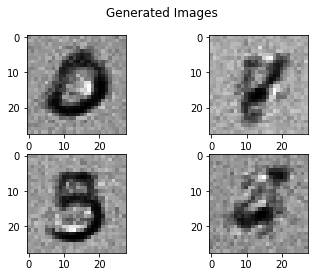


 45 100


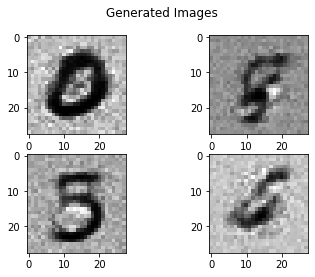


 45 200


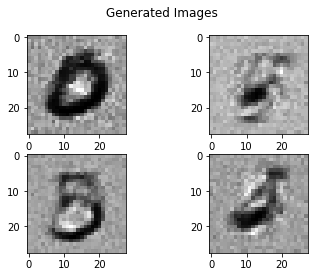


 45 300


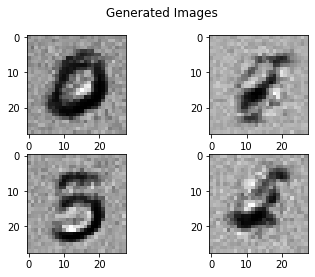


 45 400


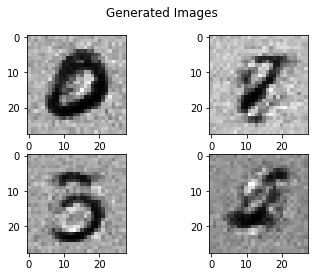


 45 500


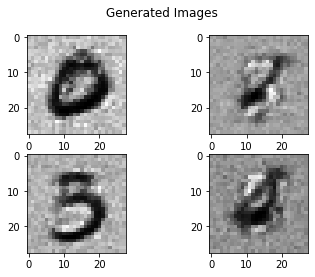


 46 0


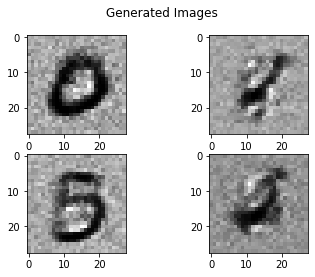


 46 100


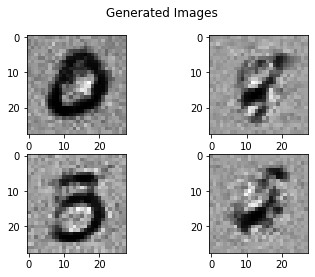


 46 200


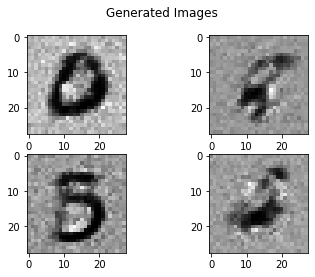


 46 300


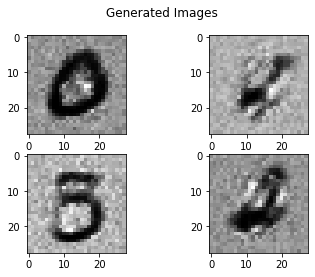


 46 400


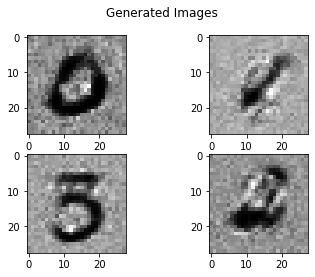


 46 500


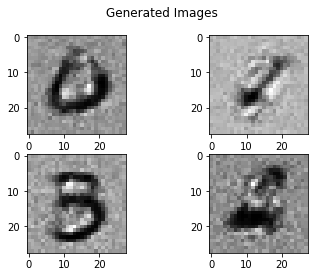


 47 0


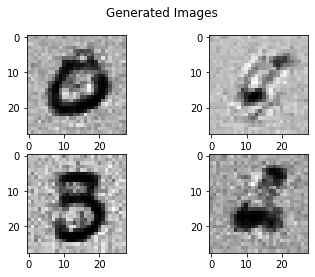


 47 100


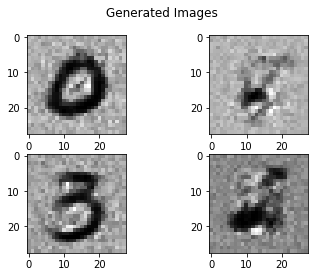


 47 200


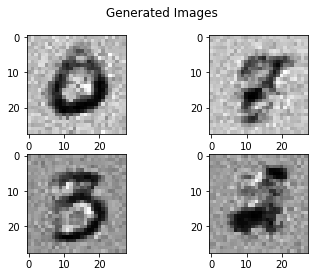


 47 300


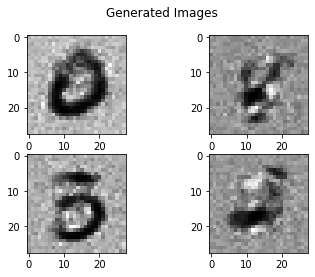


 47 400


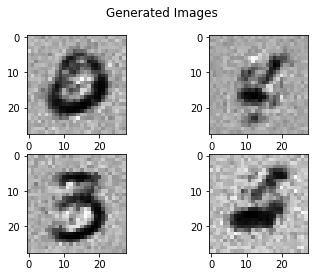


 47 500


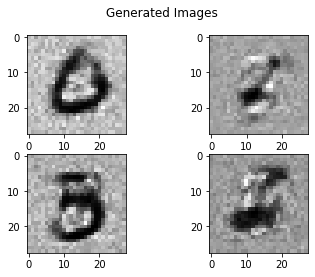


 48 0


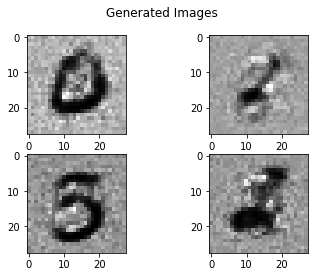


 48 100


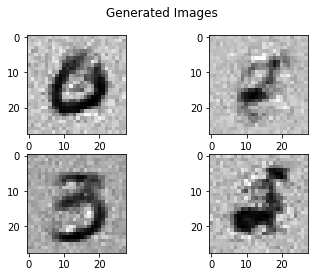


 48 200


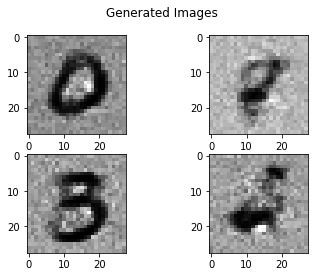


 48 300


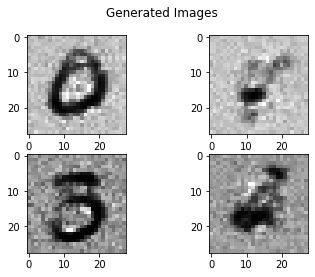


 48 400


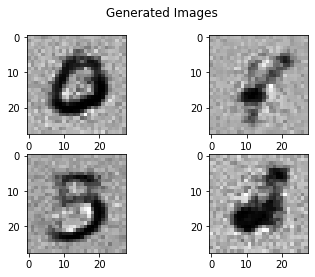


 48 500


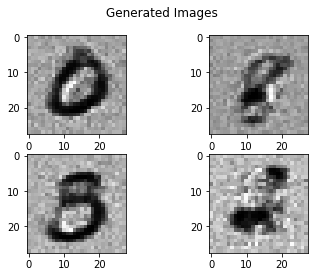


 49 0


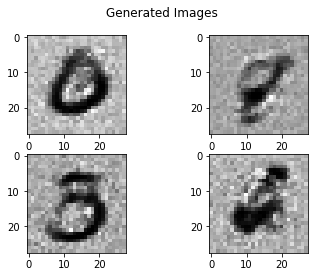


 49 100


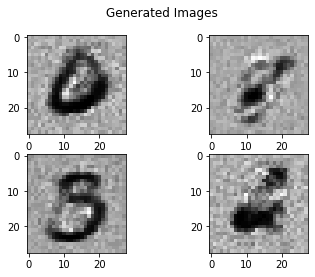


 49 200


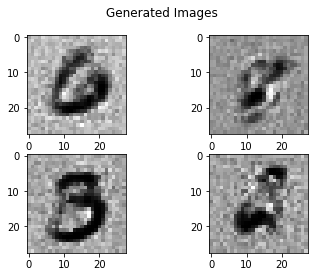


 49 300


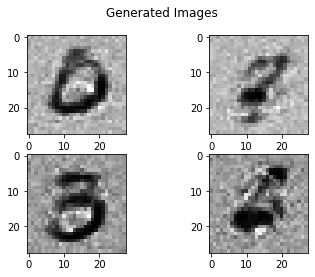


 49 400


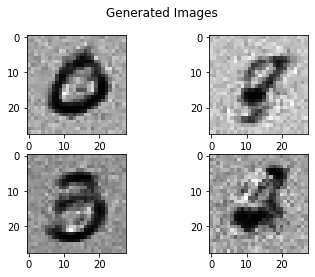


 49 500


In [20]:
epochs = 50
for epoch in range(epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        n = real_batch.size(0) # 100 = batch_size here
        
        # train discriminator
        real_data = image_to_vector(real_batch).cuda()
        fake_data = g(noise(n)).detach().cuda() # no gradient calculation for generator
        # real_data.shape, fake_data.shape = torch.Size([100, 784]) , torch.Size([100, 784])
        d_error = train_dis(d_optimizer, real_data, fake_data)
        
        # train generator
        fake_data = g(noise(n)).cuda()
        g_error = train_gen(g_optimizer, fake_data) 
        
        if (n_batch)%100 == 0:
            test_images = vector_to_image(g(test_noise))
            test_images = test_images.data
            display_image(test_images)
            print("\n",epoch, n_batch)
        